In [1]:
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from citrination_client import CitrinationClient
from xrsdkit.tools.citrination_tools import get_data_from_Citrination

In [47]:
from xrsdkit.models.structure_classifier import StructureClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import sklearn

In [5]:
with open("citrination_api_key_ssrl.txt", "r") as g: 
    api_key = g.readline()
a_key = api_key.strip()
client = CitrinationClient(site='https://slac.citrination.com',api_key=a_key )

In [6]:
data = get_data_from_Citrination(client = client, dataset_id_list= [21,22,23,28,29,30,31,32,33,34,35,36])

In [7]:
data.head()

,experiment_id,Imax_over_Imean,Imax_sharpness,I_fluctuation,logI_fluctuation,logI_max_over_std,r_fftIcentroid,r_fftImax,q_Icentroid,q_logIcentroid,...,pop1_a,pop1_site0_D,pop1_site0_r,pop1_site0_r0,pop1_site0_rg,pop1_site0_sigma,pop2_a,pop2_site0_r,pop2_site0_r0,pop2_site0_sigma
376,R2,39.5801,1.54567,0.00217768,5.49704,3.43493,0.0466834,0.00185529,0.076234,-0.704151,...,None,None,None,None,None,None,None,None,None,None
798,R12,1.2655,1.1164,0.00986993,4.30075,2.69795,0.110857,0.00171821,0.348202,0.378675,...,None,None,None,None,None,None,None,None,None,None
1009,Reaction_A,63.5364,3.43294,0.00307733,107.087,4.06833,0.0976182,0.00238663,0.101314,0.118549,...,None,None,None,34.80535114831485,None,0.14325581731214432,114.90119671406727,32.79920949766129,None,None
633,R12,42.2665,2.14712,0.0022461,6.52532,3.35319,0.0661984,0.00171821,0.10732,1.23266,...,None,None,None,None,None,None,None,None,None,None
1081,Reaction_B,1.20771,1.02464,0.00683525,3.90982,4.69168,0.123536,0.00238663,0.349885,0.35159,...,None,None,None,None,None,None,None,None,None,None


In [8]:
data.shape

(1440, 36)

In [9]:
data.experiment_id.value_counts()

R12           306
R1            293
R3            145
R2            120
R13           103
Reaction_C     88
Reaction_A     76
Reaction_D     70
Reaction_B     65
Reaction_H     63
Reaction_E     60
Reaction_G     51
Name: experiment_id, dtype: int64

In [10]:
data.populations.value_counts()

pop0_diffuse__site0_spherical_normal                                                                                       509
Noise                                                                                                                      443
pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod                                               117
pop0_diffuse__site0_guinier_porod                                                                                          112
pop0_hard_spheres__site0_guinier_porod                                                                                     106
pop0_diffuse__site0_spherical_normal__pop1_fcc__site0_spherical                                                             54
pop0_diffuse__site0_guinier_porod__pop1_diffuse__site0_spherical_normal__pop2_fcc__site0_spherical                          41
pop0_diffuse__site0_spherical_normal__pop1_diffuse__site0_guinier_porod__pop2_fcc__site0_spherical             

**we have 11 classes**.

## Data Visualization

In [12]:
# for data visualization I will use the features that we are using for classificaion:
my_cols = ['Imax_over_Imean', 'Imax_sharpness', 'I_fluctuation',
       'logI_fluctuation', 'logI_max_over_std', 'r_fftIcentroid', 'r_fftImax',
       'q_Icentroid', 'q_logIcentroid', 'pearson_q', 'pearson_q2',
       'pearson_expq', 'pearson_invexpq']

In [13]:
vis_data = data
vis_data[my_cols] = preprocessing.scale(vis_data[my_cols])

In [14]:
from sklearn.decomposition import PCA

def doPCA(data, num_of_componets):
    pca = PCA(n_components=num_of_componets)
    pca.fit(data)
    return pca

In [34]:
pca = doPCA(vis_data[my_cols], 2)
transformed_data = pca.transform(vis_data[my_cols])

In [18]:
vis_data['pca0'] = transformed_data[ : ,0]
vis_data['pca1'] = transformed_data[ : ,1]

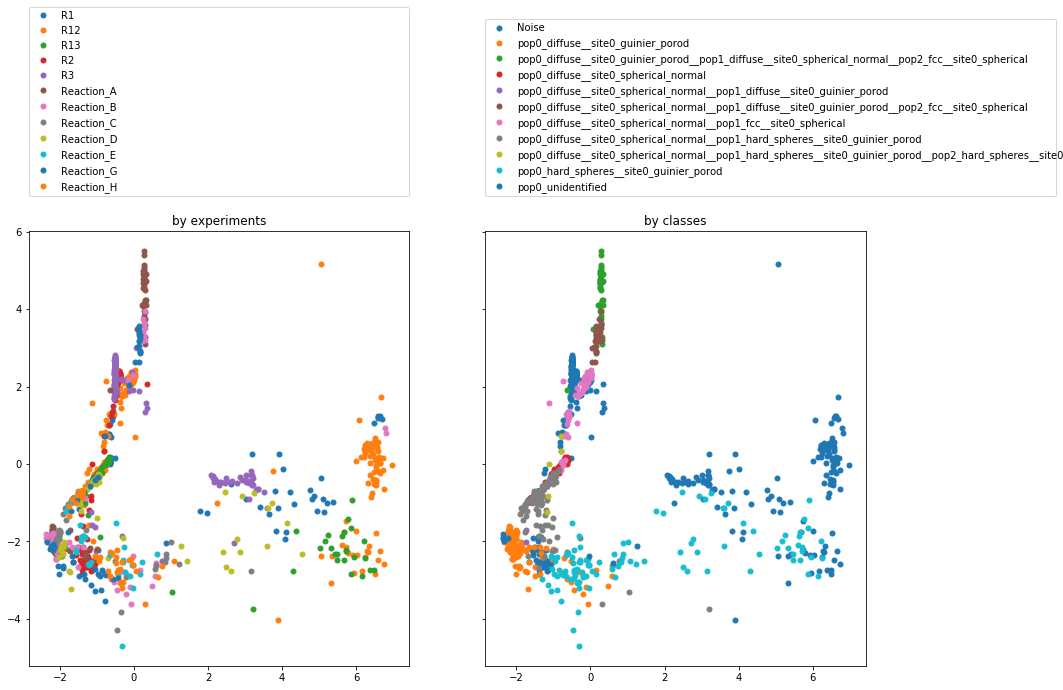

In [33]:
groups = vis_data.groupby('experiment_id')
groups2 = vis_data.groupby('populations')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('by experiments')
ax1.legend(bbox_to_anchor=(0., 1.08, 1., .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

for name, group in groups2:
    ax2.plot(group.pca0, group.pca1, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('by classes')
ax2.legend(bbox_to_anchor=(0., 1.08, 1.5, .102), loc=4,
           ncol=1, mode="expand", borderaxespad=0.)

plt.show()

## Train xrsdkit classifier and make prediction 
To see how well our classifier works we are using cross validation: when we want to predict classes for the data from experiment A, we train the models on all data excluding experiment A and then use the model to make prediction for data from experiment A. 

Restriction: it testing data includes classes labeled A,B,C and training data includes classes A,B,D,F, we do not try make a prediction for data with label "C", since we do not use this label at training time.  

In [37]:
my_classifier = StructureClassifier("populations")
results, data_with_predictios = my_classifier.train(data, hyper_parameters_search = True)

R2
0.733333333333
R12
0.767973856209
Reaction_A
0.771428571429
Reaction_B
0.430769230769
R1
0.839590443686
R13
0.728155339806
Reaction_E
0.733333333333
Reaction_C
0.397727272727
Reaction_D
0.328571428571
R3
0.944827586207
Reaction_H
0.873015873016
Reaction_G
0.529411764706


We got very different accuracies: 0.94 for experiment R3 and 0.32 for Reaction_D. We have 11 classes and random guess could give us about 0.09 accuracy. Thus, the result is not very bad. 

## Error Analytics

In [44]:
pr = data_with_predictios[0]
for df in data_with_predictios[1: ]:
    pr = pr.append(df)

In [110]:
len(pr)

1399

"pr" dataframe contains only data for which we were able to make a prediction. As I mentioned above, we do not try make a prediction for samples with classes that were not included in training set.

In [108]:
pr.populations.value_counts()

pop0_diffuse__site0_spherical_normal                                                                                       509
Noise                                                                                                                      443
pop0_diffuse__site0_spherical_normal__pop1_hard_spheres__site0_guinier_porod                                               117
pop0_diffuse__site0_guinier_porod                                                                                          112
pop0_hard_spheres__site0_guinier_porod                                                                                     106
pop0_diffuse__site0_spherical_normal__pop1_fcc__site0_spherical                                                             54
pop0_diffuse__site0_spherical_normal__pop1_diffuse__site0_guinier_porod__pop2_fcc__site0_spherical                          33
pop0_diffuse__site0_spherical_normal__pop1_diffuse__site0_guinier_porod                                        

In [103]:
classes = set(pr['populations'].unique())
classes.update(pr['predicted_class'])
classes = sorted(list(classes))

Text(0.5,0,'Predicted label')

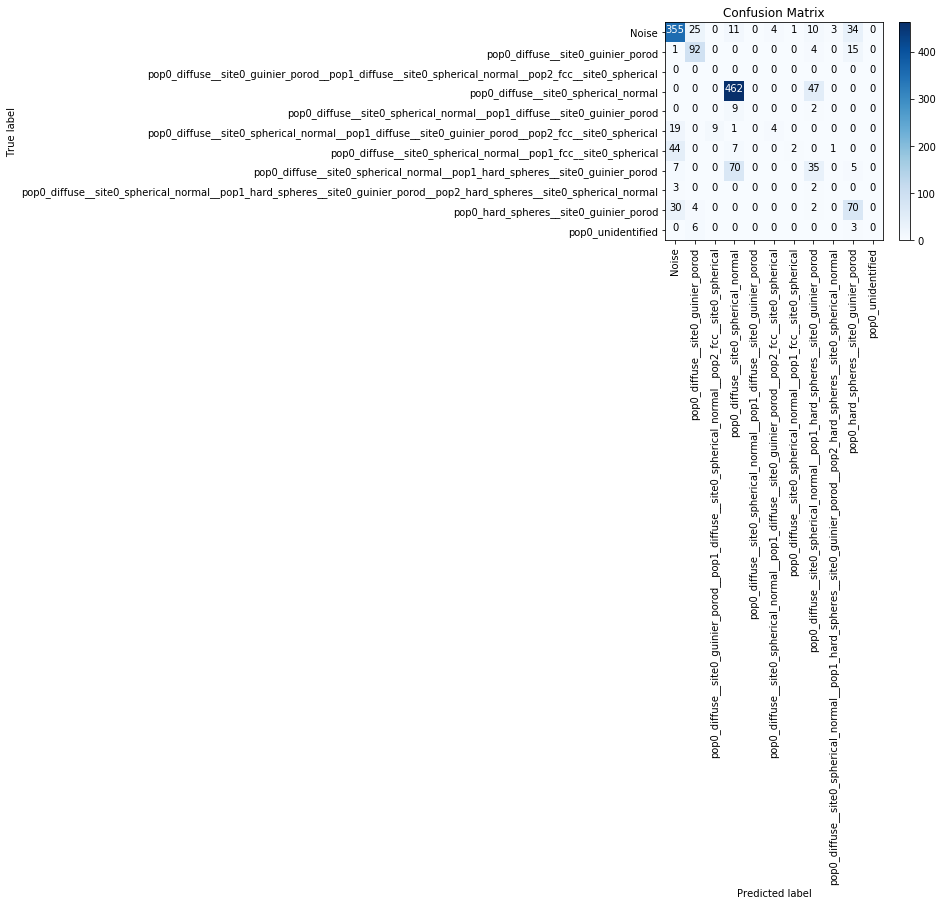

In [111]:
import itertools

cm = confusion_matrix(pr['populations'], pr['predicted_class'])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # to normalize
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

#fmt = '.1f'
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')